## Water bodies detection

In this tutorial, we are going detect the water bodies from satellite imagery.


### Dataset

Input data are 4 bands (RGB and NIR) satellite images. And output are binary images. Pixel value is 0 for non-water bodies and pixel value is 1 for water bodies.



In [1]:
# import necessary libraries
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

In [2]:
# connect google drive
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# set the working directory
import os
os.chdir(r'/content/gdrive/MyDrive/dl/water_bodies')

## Data preprocessing

In [4]:
train_xx_initial = np.load('X_train.npy')
train_yy_initial = np.load('y_train.npy')
test_xx = np.load('X_test.npy')
test_yy = np.load("y_test.npy")

print(train_xx_initial.shape, train_yy_initial.shape, test_xx.shape, test_yy.shape)

(442, 256, 256, 4) (442, 256, 256, 1) (280, 256, 256, 4) (280, 256, 256, 1)


### Data Agumentation

In [5]:
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import numpy as np

# Define augmentation pipeline
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Flipud(0.5),  # Vertical flip
    iaa.Affine(rotate=(-45, 45)),  # Random rotation between -45 and 45 degrees
    iaa.Affine(scale=(0.5, 1.5)),  # Random scaling between 0.5x and 1.5x
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),  # Random translation
    # iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Gaussian noise
    # iaa.ElasticTransformation(alpha=50, sigma=5)  # Elastic deformation
])

In [6]:
augmented_images = []
augmented_masks = []

num_augmentations = 3
# Apply augmentation to each original image and mask
for i in range(train_xx_initial.shape[0]):
    image = train_xx_initial[i]
    mask = train_yy_initial[i]

    # Create a segmentation map object from the mask
    segmentation_map = SegmentationMapsOnImage(mask, shape=image.shape)

    # Apply augmentation num_augmentations times
    for _ in range(num_augmentations):
        # Apply the same augmentation to both image and mask
        augmented_image, augmented_segmentation_mask = seq.augment(image=image, segmentation_maps=segmentation_map)

        # Append the augmented image and mask to the lists
        augmented_images.append(augmented_image)
        augmented_masks.append(augmented_segmentation_mask.get_arr())

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

In [7]:
# append augmented images/masks with original images/masks
train_xx = np.concatenate((train_xx_initial, augmented_images), axis=0)
train_yy = np.concatenate((train_yy_initial, augmented_masks), axis=0)

In [8]:
# release memory
del augmented_images
del augmented_masks

In [9]:
train_xx.max(), train_xx.min(), train_xx.dtype

(1.0, 0.0, dtype('float32'))

In [10]:
train_xx.shape, train_yy.shape

((1768, 256, 256, 4), (1768, 256, 256, 1))

In [11]:
num_samples = train_xx.shape[0]
shuffled_indices = np.random.permutation(num_samples)

train_xx = train_xx[shuffled_indices]
train_yy = train_yy[shuffled_indices]

1589


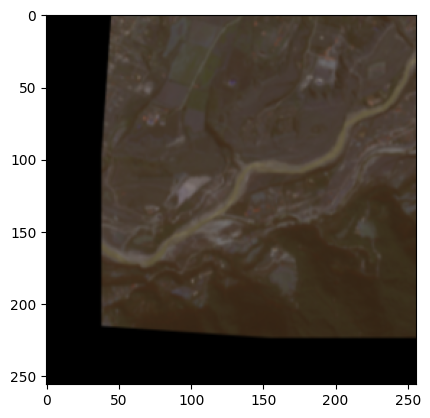

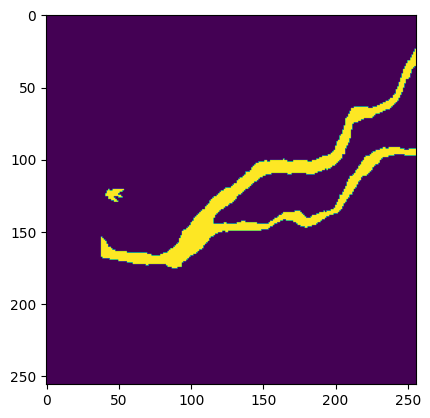

In [14]:
# Let's plot a sample input RGB image and output image with buildings
img = np.random.randint(0, 1768)
print(img)
plt.imshow(train_xx[img, :, :, :3])
plt.show()
plt.imshow(train_yy[img, :, :, 0])
plt.show()

## U-Net model development
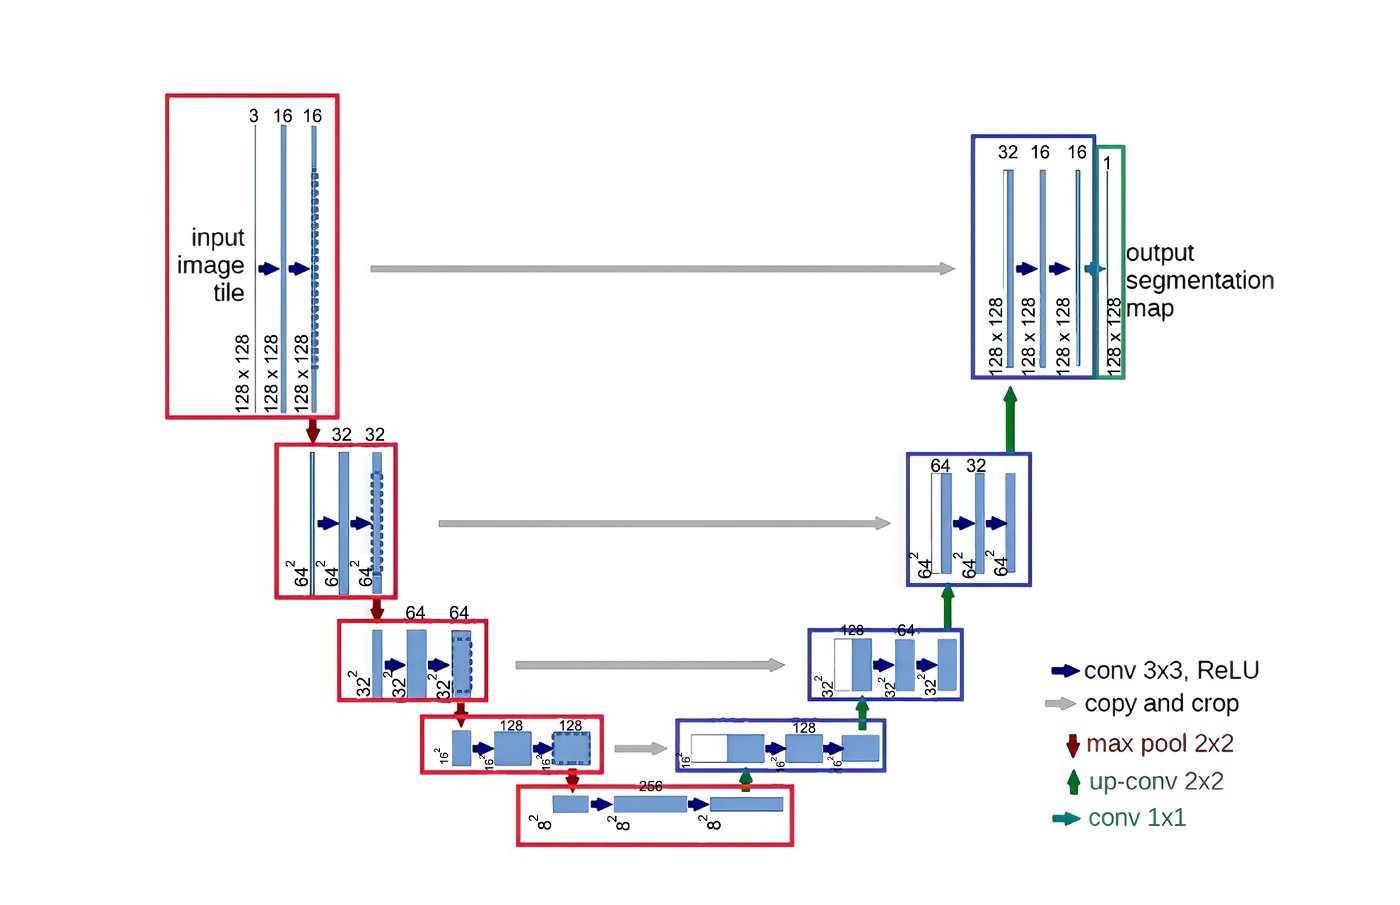


In [15]:
x_in = Input(shape=(256, 256, 4))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)
# use sigmoid activation here because output values are either 0 or 1

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss='binary_crossentropy', optimizer='adam')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
!pip install tensorflow==2.12.0

In [16]:
# training model
import tensorflow as tf

# callback function to stop overfitting the model
checkpointer = tf.keras.callbacks.ModelCheckpoint("best_weight.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

callbacks = [
    earlyStopping,
    checkpointer
    ]
history = model.fit(train_xx, train_yy,
                    validation_data=(test_xx, test_yy),
                    epochs=100,
                    batch_size=8,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/100
221/221 [==============================] - 47s 153ms/step - loss: 0.1063 - val_loss: 0.2094

Epoch 1: val_loss improved from inf to 0.20936, saving model to best_weight.h5
Epoch 2/100
221/221 [==============================] - 34s 153ms/step - loss: 0.0681 - val_loss: 0.1973

Epoch 2: val_loss improved from 0.20936 to 0.19731, saving model to best_weight.h5
Epoch 3/100
221/221 [==============================] - 35s 156ms/step - loss: 0.0661 - val_loss: 0.1907

Epoch 3: val_loss improved from 0.19731 to 0.19068, saving model to best_weight.h5
Epoch 4/100
221/221 [==============================] - 34s 154ms/step - loss: 0.0639 - val_loss: 0.2084

Epoch 4: val_loss did not improve from 0.19068
Epoch 5/100
221/221 [==============================] - 34s 153ms/step - loss: 0.0630 - val_loss: 0.2043

Epoch 5: val_loss did not improve from 0.19068
Epoch 6/100
221/221 [==============================] - 34s 153ms/step - loss: 0.0631 - val_loss: 0.2442

Epoch 6: val_loss did not impro

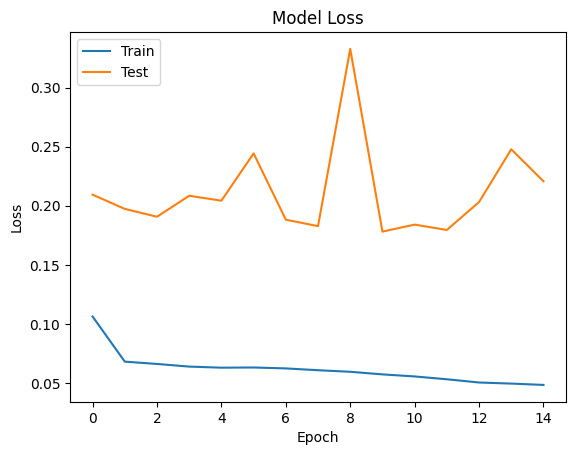

In [17]:
# plot model loss over training and validation data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction

In [19]:
from tensorflow.keras.models import load_model
model = load_model('best_weight.h5')

9/9 [==============================] - 1s 142ms/step
(280, 256, 256, 1)


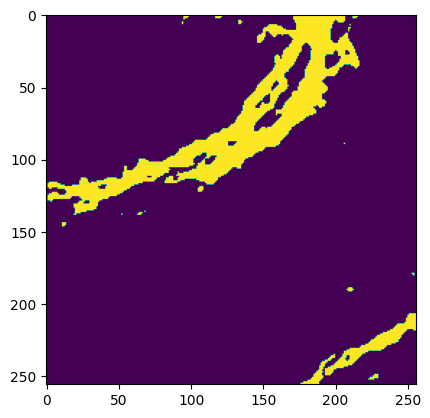

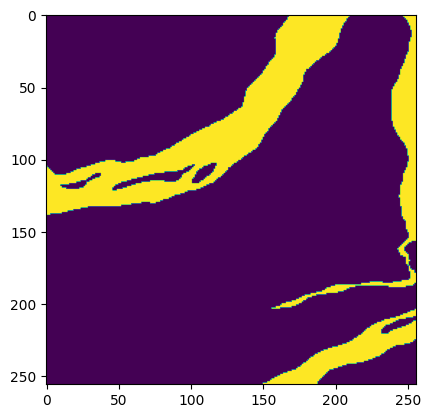

In [22]:
threshold = 0.5

# prediction of the output
pred_test = model.predict(test_xx)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

#let's comare random predicted and actial y values
img = np.random.randint(0, 282)
plt.imshow(pred_test[img, :, :, 0])
plt.show()
plt.imshow(test_yy[img,:,:,0])
plt.show()

This is not an operational model with high accuracy. But with more layers and with more data, we can develop this architecture in to an operational model with high accuracy.